In [1]:
%matplotlib inline
from collections import defaultdict
from math import exp, log
from random import random
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## setup

In [2]:
rounds = 1_000
win_pcts_four_team_example = np.array([
    [0, 0.6, 0.7, 0.8],
    [0, 0,   0.6, 0.7],
    [0, 0,   0,   0.6],
    [0, 0,   0,   0],
])
win_pcts = np.array([
    [0, lambda r: 0.7+0.25*r/rounds],
    [0, 0]
])

In [3]:
def create_data(win_pcts, rounds=10, as_dataframe=True):
    teams = len(win_pcts)
    recs = []
    # arr = np.random.random(size=(10_000, *win_pcts.shape)) < win_pcts
    for r in range(rounds):
        # enumerate upper triangle
        for team_a in range(teams):
            for team_b in range(team_a+1, teams):
                team_a_win_pct = win_pcts[team_a, team_b](r)
                team_a_wins = random() < team_a_win_pct
                recs.append((team_a, team_b, r, team_a_wins))
    if as_dataframe:
        return pd.DataFrame(recs, columns=['team_a', 'team_b', 'round', 'team_a_wins'])
    return recs

In [4]:
recs = create_data(win_pcts, rounds=rounds, as_dataframe=False)
df = pd.DataFrame(recs, columns=['team_a', 'team_b', 'round', 'team_a_wins'])

## logreg

In [5]:
sample_weights = np.exp(np.arange(rounds)/1e2)
# plt.plot(range(rounds), sample_weights)

In [6]:
# x = I(server) - I(receiver)
ta = pd.get_dummies(df['team_a'], dtype=np.int8)
tb = pd.get_dummies(df['team_b'], dtype=np.int8)
x = ta.subtract(tb, fill_value=0).astype(np.int8).values
y = df['team_a_wins'].values
# high C is a low penalty
clf = LogisticRegression(C=1e-1, fit_intercept=False, solver='lbfgs')
clf.fit(x, y)
clf.coef_

array([[ 0.81036694, -0.81036694]])

In [7]:
# consecutive fits
coefs = []
for i in range(rounds):
    try:
        clf.fit(x[:i+1], y[:i+1], sample_weight=sample_weights[:i+1])
        # clf.fit(x[:i], y[:i])
        coefs.append(clf.coef_[0])
    except ValueError as err:
        print(err)
        coefs.append([0, 0])
coefs = np.array(coefs)

This solver needs samples of at least 2 classes in the data, but the data contains only one class: True


In [8]:
clf.fit(x, y)
clf.coef_

array([[ 0.81036694, -0.81036694]])

## elo

In [9]:
mean_rating = 0  # also the starting rating
ratings = defaultdict(lambda: mean_rating)
k = 1/20
# elo width/scale is just a rescaling so don't worry about it
post_ratings = []
for i, (team_a, team_b, r, team_a_wins) in enumerate(recs):
    ratings_diff = ratings[team_a] - ratings[team_b]
    expected_result = 1.0 / (1 + exp(-ratings_diff))
    change_in_rating = k*(team_a_wins - expected_result)
    ratings[team_a] += change_in_rating
    ratings[team_b] -= change_in_rating
    post_ratings.append((ratings[team_a], ratings[team_b]))

In [10]:
df = pd.DataFrame(recs, columns=['team_a', 'team_b', 'round', 'team_a_wins'])
dfr = pd.DataFrame(post_ratings, columns=['r_team_a', 'r_team_b'])
df = df.join(dfr)
df.head()

,team_a,team_b,round,team_a_wins,r_team_a,r_team_b
0,0,1,0,True,0.025000,-0.025000
1,0,1,1,False,-0.000625,0.000625
2,0,1,2,True,0.024391,-0.024391
3,0,1,3,True,0.048781,-0.048781
4,0,1,4,True,0.072563,-0.072563


## compare

In [11]:
def logistic(x):
    return 1 / (1 + np.exp(-x))
def logit(x):
    return np.log(x/(1-x))

In [12]:
# divide the ratings diff by 2
true_rating = logit(win_pcts[0, 1](np.arange(rounds))) / 2

Text(0, 0.5, 'strength')

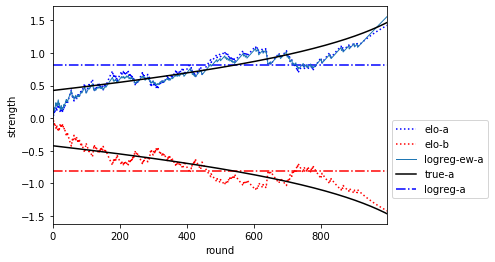

In [13]:
df.loc[df['team_a'] == 0, 'r_team_a'].plot(c='blue', label='elo-a', linestyle=':')
df.loc[df['team_b'] == 1, 'r_team_b'].plot(c='red', label='elo-b', linestyle=':')
plt.hlines(clf.coef_[0, 0], 0, rounds, color='blue', label='logreg-a', linestyle='-.')
plt.hlines(clf.coef_[0, 1], 0, rounds, color='red', linestyle='-.')
plt.plot(range(rounds), coefs[:, 0], label='logreg-ew-a', linewidth=1)
plt.plot(range(rounds), true_rating, color='black', label='true-a')
plt.plot(range(rounds), -true_rating, color='black')
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.xlabel('round')
plt.ylabel('strength')

In [14]:
elo_win_probs = logistic(df['r_team_a'] - df['r_team_b'])
logreg_win_probs = logistic(coefs[:, 0] - coefs[:, 1])

1.1564468200135007

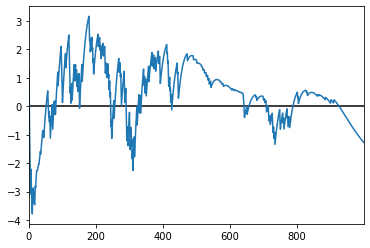

In [15]:
error = (elo_win_probs - logreg_win_probs) * 100
error.plot()
plt.hlines(0, 0, rounds)
np.sqrt(error.pow(2).mean())
# logreg and elo are pretty similar!

1. elo is just gradient descent updates of logistic regression, so if team strength is constant and there are enough rounds, elo will converge to a logreg solution
2. if strength is non constant (shown here increasing), logreg will estimate the average strength
3. you can partially fix this by weighted observations of the logreg (shown here is exponential decay on the weights)
4. This suggests that a natural way to include covariates in an Elo style model is to simply weight observations by time. The weighting scheme can be tuned by cross validation. Probably need to take care with players that only play a few matches though

(Pretty sure you can just include covariates in Elo as part of the ratings difference term, but then you need to write a method of optimising all these parameters- however I think gradient descent works fine)

5. By increasing the coefficient penalty, we can actually account for 4 (eg. try changing C=1e-1 above)
6. Pretty sure all this can be proven by looking at the loss functions